# H2 — Weighted LFP Correlation: Aversive vs Non-Aversive

## Comparaisons

Les epochs sont regroupées par **numéro de stage** (I ou II), en poolant REM et NREM ensemble :

| Groupe | Contenu aversive | Contenu non-aversive |
|--------|-----------------|----------------------|
| **Stage I** | NREM I + REM I | NREM I + REM I |
| **Stage II** | NREM II + REM II | NREM II + REM II |

## Pondération

Deux approches comparées :
1. **Par epoch** : une corrélation de Pearson par epoch, pondérée par sa durée dans les statistiques
2. **Globale** : concaténation de tous les segments LFP du groupe → une valeur unique

## Tests statistiques
- **Mann-Whitney U** : non-paramétrique, compare les rangs
- **Kolmogorov-Smirnov** : compare la forme entière de la distribution
- **Permutation test** : sans hypothèse distributionnelle

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

In [50]:
df_aversive   = pd.read_pickle("data/lfp_epochs_with_spikes_by_region-av-2.pkl")
df_nonaversive = pd.read_pickle("data/lfp_epochs_with_spikes_by_region-rw-2.pkl")

# --- Groupes : Stage I (NREM I + REM I) et Stage II (NREM II + REM II) ---
STAGE_I_LABELS  = {'NREM I',  'REM I'}
STAGE_II_LABELS = {'NREM II', 'REM II'}

df_av_s1  = df_aversive[df_aversive['epoch_label'].isin(STAGE_I_LABELS)].reset_index(drop=True)
df_av_s2  = df_aversive[df_aversive['epoch_label'].isin(STAGE_II_LABELS)].reset_index(drop=True)
df_nav_s1 = df_nonaversive[df_nonaversive['epoch_label'].isin(STAGE_I_LABELS)].reset_index(drop=True)
df_nav_s2 = df_nonaversive[df_nonaversive['epoch_label'].isin(STAGE_II_LABELS)].reset_index(drop=True)

def duration_stats(df, label):
    d = df['t_end'] - df['t_start']
    counts = df['epoch_label'].value_counts().to_dict()
    print(f"  {label:<28} n={len(df):>4}  "
          f"mean={d.mean():.1f}s  min={d.min():.1f}s  max={d.max():.1f}s  "
          f"{counts}")

print("Composition des groupes :")
duration_stats(df_av_s1,  "Aversive   — Stage I ")
duration_stats(df_nav_s1, "Non-Aversive — Stage I ")
duration_stats(df_av_s2,  "Aversive   — Stage II")
duration_stats(df_nav_s2, "Non-Aversive — Stage II")

Composition des groupes :
  Aversive   — Stage I         n=  52  mean=77.0s  min=7.0s  max=264.0s  {'NREM I': 32, 'REM I': 20}
  Non-Aversive — Stage I       n= 362  mean=22.7s  min=1.0s  max=424.0s  {'NREM I': 184, 'REM I': 178}
  Aversive   — Stage II        n=  43  mean=105.0s  min=25.0s  max=343.0s  {'NREM II': 26, 'REM II': 17}
  Non-Aversive — Stage II      n= 396  mean=18.4s  min=0.0s  max=235.0s  {'NREM II': 203, 'REM II': 193}


In [51]:
PAIRS = [
    ('vHPC_lfp', 'dHPC_lfp', 'vHPC ↔ dHPC', '#1f77b4'),
    ('bla_lfp',  'dHPC_lfp', 'BLA ↔ dHPC',  '#ff7f0e'),
    ('bla_lfp',  'vHPC_lfp', 'BLA ↔ vHPC',  '#2ca02c'),
]

STAGES = [
    ('Stage I',  df_av_s1, df_nav_s1),
    ('Stage II', df_av_s2, df_nav_s2),
]


def compute_weighted_correlations(df, name1, name2, min_samples=1000, min_std=0.01):
    """
    Corrélation de Pearson par epoch + poids (durée en secondes).
    min_samples=1000 ~ 0.8s à 1250 Hz.
    Retourne (corrs, weights) — NaN/0 pour les epochs invalides.
    """
    corrs   = np.full(len(df), np.nan)
    weights = np.zeros(len(df))
    for i, (_, row) in enumerate(df.iterrows()):
        sig1 = np.asarray(row[name1])
        sig2 = np.asarray(row[name2])
        if (len(sig1) < min_samples or
            np.std(sig1) < min_std or
            np.std(sig2) < min_std):
            continue
        corrs[i]   = np.corrcoef(sig1, sig2)[0, 1]
        weights[i] = row['t_end'] - row['t_start']
    return corrs, weights


def compute_global_correlation(df, name1, name2, min_samples=1000, min_std=0.01):
    """Concatène tous les segments LFP valides → une corrélation globale unique."""
    segs1, segs2 = [], []
    for _, row in df.iterrows():
        sig1 = np.asarray(row[name1])
        sig2 = np.asarray(row[name2])
        if (len(sig1) >= min_samples and
            np.std(sig1) >= min_std and
            np.std(sig2) >= min_std):
            segs1.append(sig1)
            segs2.append(sig2)
    if not segs1:
        return np.nan, 0
    all1 = np.concatenate(segs1)
    all2 = np.concatenate(segs2)
    return np.corrcoef(all1, all2)[0, 1], len(all1)


def weighted_mean_std(values, weights):
    """Moyenne et écart-type pondérés."""
    valid = ~np.isnan(values) & (weights > 0)
    v, w  = values[valid], weights[valid]
    wn    = w / w.sum()
    mean  = np.dot(wn, v)
    std   = np.sqrt(np.dot(wn, (v - mean) ** 2))
    return mean, std


def sig_label(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'


def run_distribution_tests(d_av, d_nav, w_av, w_nav, n_perm=10000):
    """Mann-Whitney U, KS test, Permutation test sur la différence de moyennes pondérées."""
    mwu_stat, mwu_p = stats.mannwhitneyu(d_av, d_nav, alternative='two-sided')
    ks_stat,  ks_p  = stats.ks_2samp(d_av, d_nav)

    obs_diff = np.average(d_av, weights=w_av) - np.average(d_nav, weights=w_nav)
    pooled   = np.concatenate([d_av, d_nav])
    n_av     = len(d_av)
    rng      = np.random.default_rng(42)
    diffs    = np.empty(n_perm)
    for k in range(n_perm):
        rng.shuffle(pooled)
        diffs[k] = pooled[:n_av].mean() - pooled[n_av:].mean()
    perm_p = np.mean(np.abs(diffs) >= np.abs(obs_diff))

    return dict(mwu_stat=mwu_stat, mwu_p=mwu_p,
                ks_stat=ks_stat,   ks_p=ks_p,
                perm_stat=obs_diff, perm_p=perm_p)


print("Fonctions définies.")

Fonctions définies.


## Diagnostic : durée vs corrélation

Vérifie si la durée de l'epoch biaise la valeur de corrélation estimée (régression linéaire + r de Pearson).

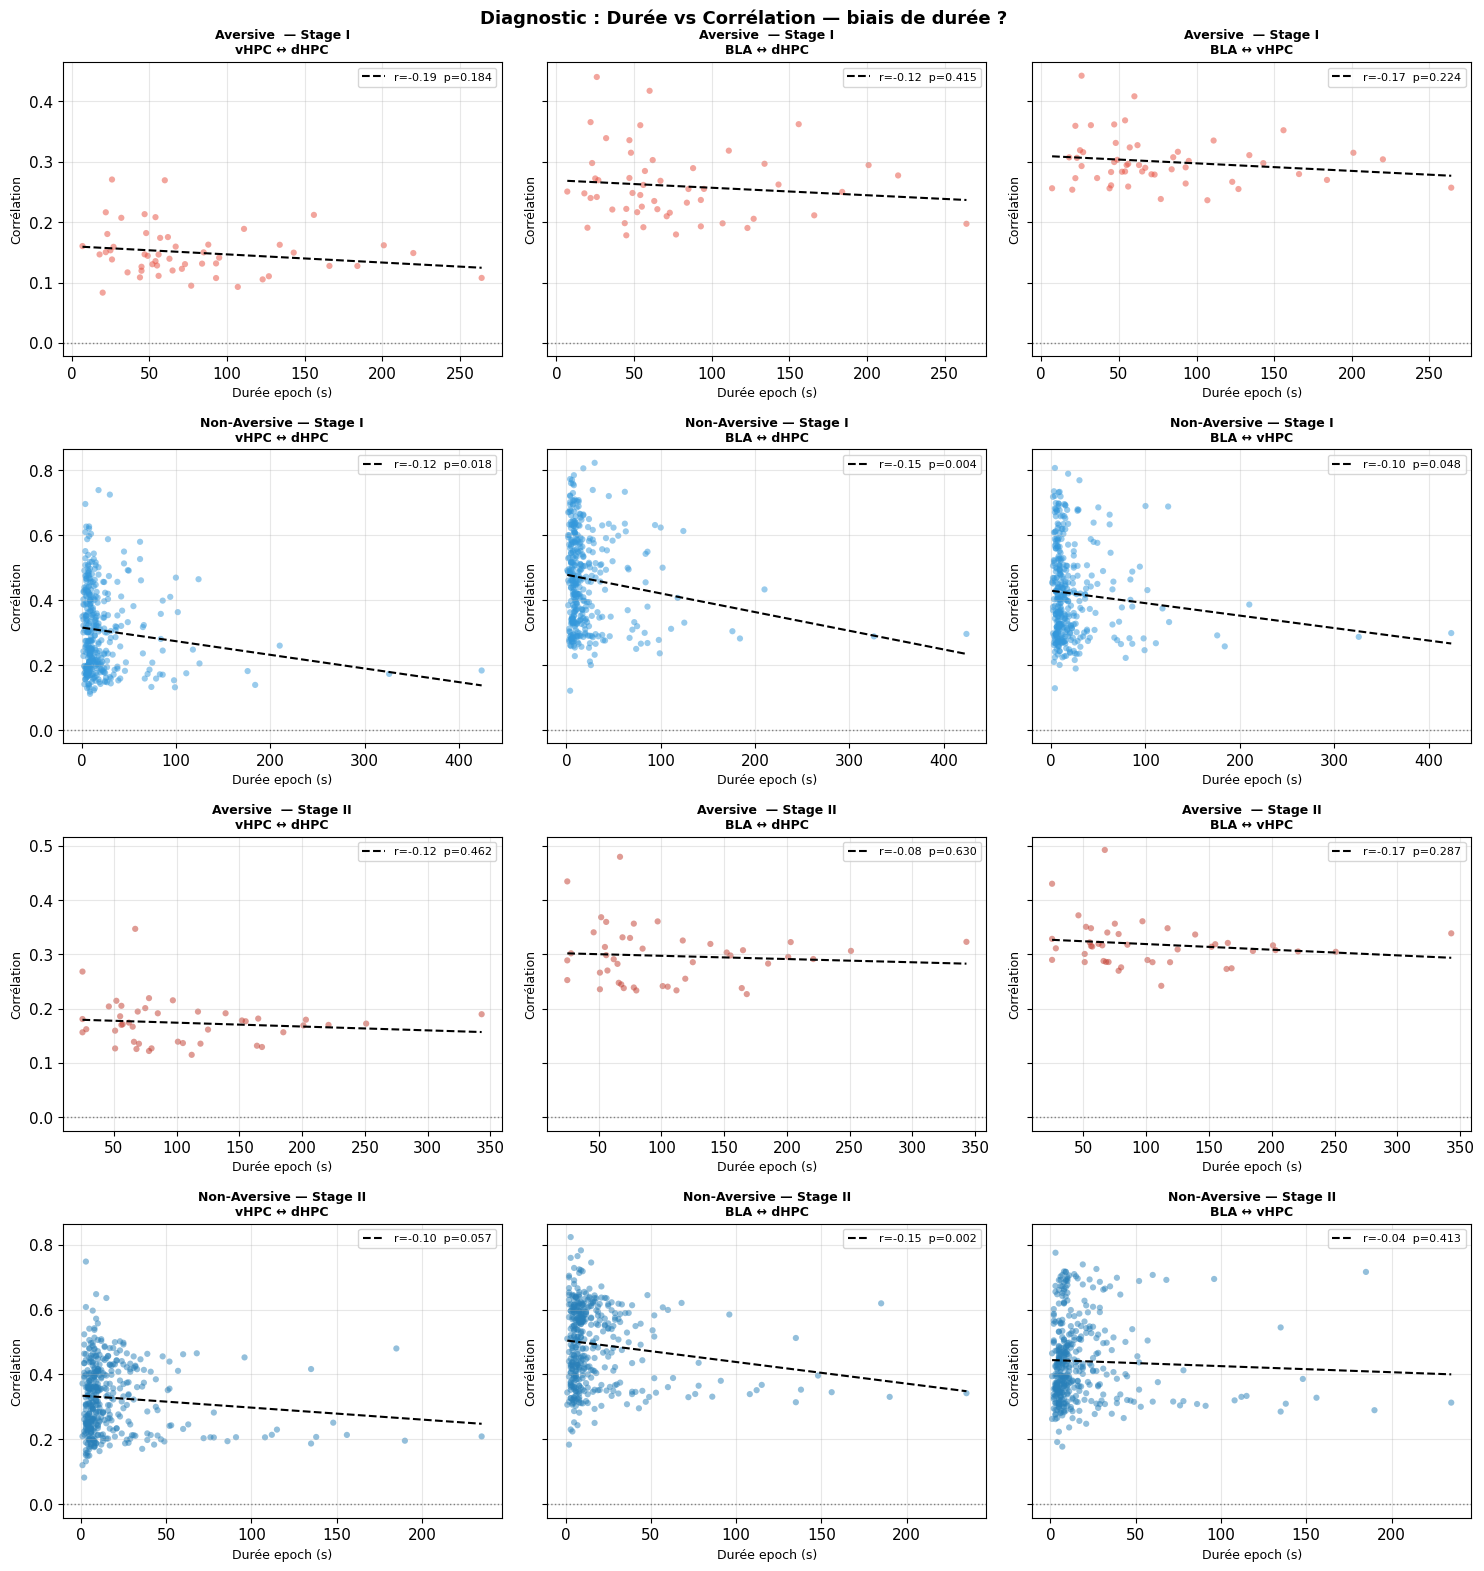

In [52]:
rows_cfg = [
    (df_av_s1,  'Aversive  — Stage I',   '#e74c3c'),
    (df_nav_s1, 'Non-Aversive — Stage I', '#3498db'),
    (df_av_s2,  'Aversive  — Stage II',  '#c0392b'),
    (df_nav_s2, 'Non-Aversive — Stage II','#2980b9'),
]

fig, axes = plt.subplots(4, 3, figsize=(15, 16), sharey='row')

for ri, (df, label, color) in enumerate(rows_cfg):
    for ci, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[ri, ci]
        corrs, weights = compute_weighted_correlations(df, n1, n2)
        valid = ~np.isnan(corrs)
        d, c  = weights[valid], corrs[valid]

        ax.scatter(d, c, alpha=0.5, s=20, color=color, edgecolors='none')
        if len(d) > 2:
            slope, intercept, r, p, _ = stats.linregress(d, c)
            xl = np.linspace(d.min(), d.max(), 100)
            ax.plot(xl, slope * xl + intercept, 'k--', lw=1.5,
                    label=f'r={r:.2f}  p={p:.3f}')
            ax.legend(fontsize=8)

        ax.axhline(0, color='gray', linestyle=':', lw=1)
        ax.set_xlabel('Durée epoch (s)', fontsize=9)
        ax.set_ylabel('Corrélation', fontsize=9)
        ax.set_title(f'{label}\n{pair_label}', fontsize=9, fontweight='bold')
        ax.grid(True, alpha=0.3)

plt.suptitle('Diagnostic : Durée vs Corrélation — biais de durée ?',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Pré-calcul des corrélations pondérées

In [53]:
# all_corrs[(stage_label, condition, pair_label)] = (corrs_valid, weights_valid)
all_corrs = {}

for stage_label, df_av, df_nav in STAGES:
    for n1, n2, pair_label, _ in PAIRS:
        for cond, df in [('Aversive', df_av), ('Non-Aversive', df_nav)]:
            c, w  = compute_weighted_correlations(df, n1, n2)
            valid = ~np.isnan(c) & (w > 0)
            all_corrs[(stage_label, cond, pair_label)] = (c[valid], w[valid])

print(f"{'Stage':<12} {'Paire':<18} {'n_av':>6} {'n_nav':>7}")
print('-' * 48)
for stage_label, _, _ in STAGES:
    for _, _, pair_label, _ in PAIRS:
        n_av  = len(all_corrs[(stage_label, 'Aversive',    pair_label)][0])
        n_nav = len(all_corrs[(stage_label, 'Non-Aversive', pair_label)][0])
        print(f"{stage_label:<12} {pair_label:<18} {n_av:>6} {n_nav:>7}")

Stage        Paire                n_av   n_nav
------------------------------------------------
Stage I      vHPC ↔ dHPC            52     362
Stage I      BLA ↔ dHPC             52     362
Stage I      BLA ↔ vHPC             52     362
Stage II     vHPC ↔ dHPC            43     395
Stage II     BLA ↔ dHPC             43     395
Stage II     BLA ↔ vHPC             43     395


## KDE pondérées + tests statistiques

Figure 2 × 3 : lignes = Stage I / Stage II, colonnes = paires de régions.

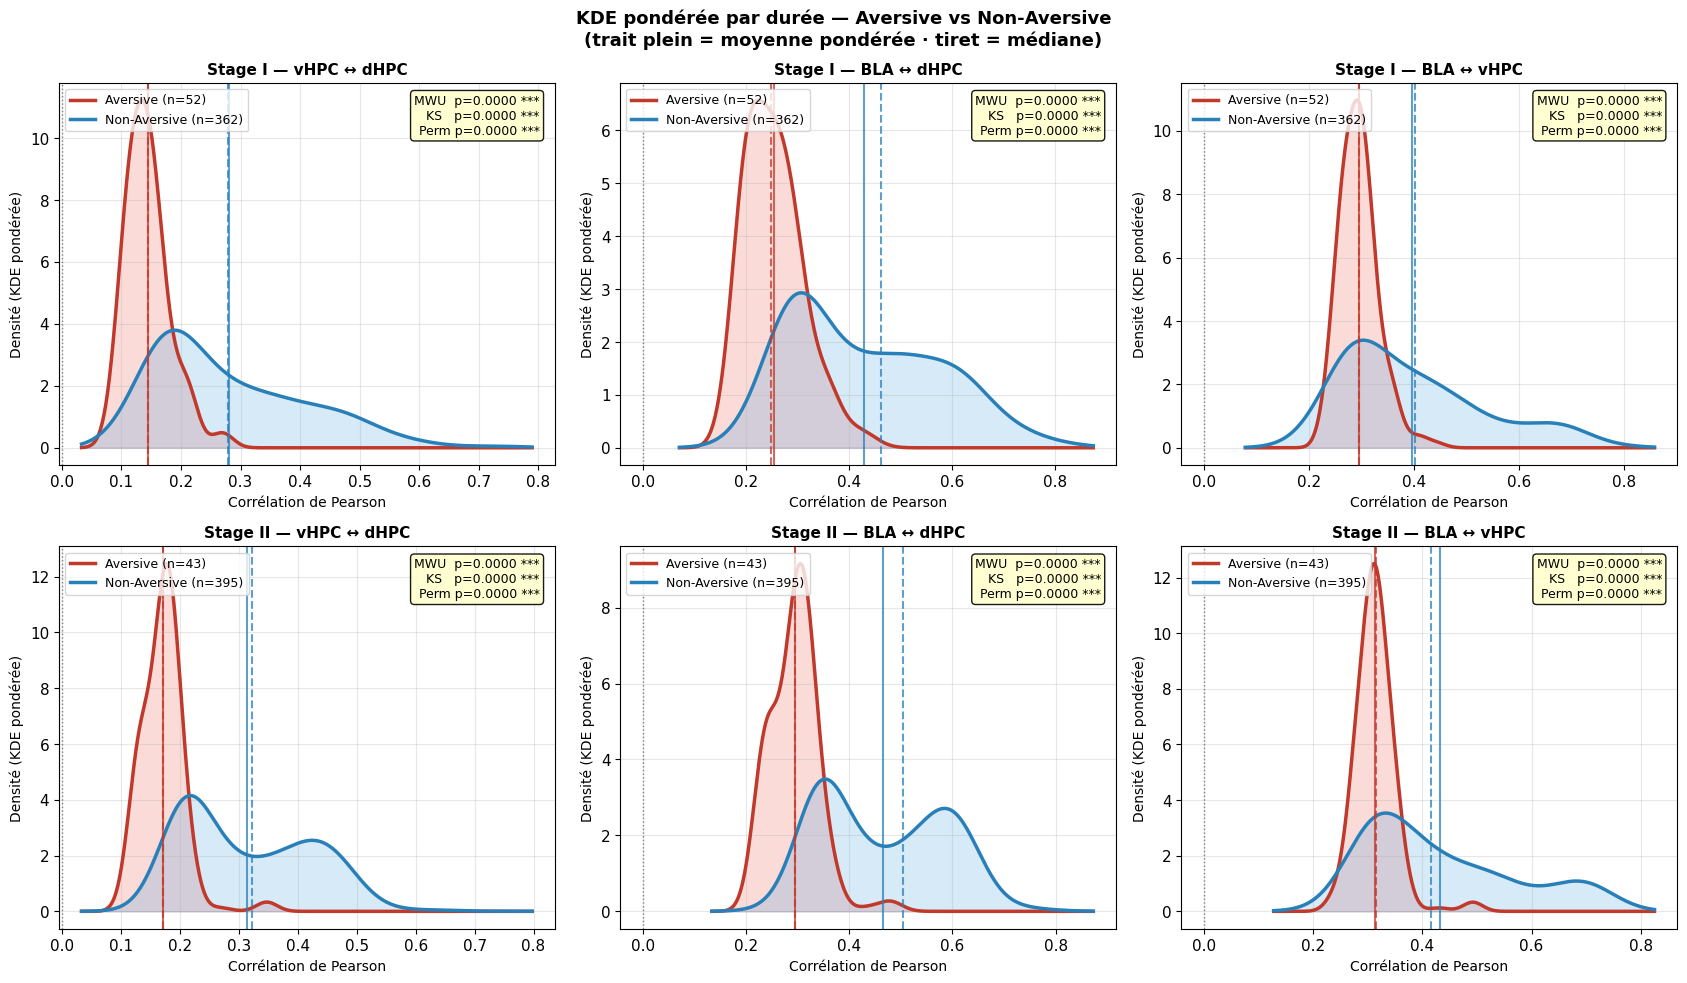

In [54]:
test_results = {}  # (stage_label, pair_label) -> dict

fig, axes = plt.subplots(2, 3, figsize=(17, 10))

for si, (stage_label, df_av, df_nav) in enumerate(STAGES):
    for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[si, pi]

        d_av,  w_av  = all_corrs[(stage_label, 'Aversive',    pair_label)]
        d_nav, w_nav = all_corrs[(stage_label, 'Non-Aversive', pair_label)]

        if len(d_av) < 3 or len(d_nav) < 3:
            ax.text(0.5, 0.5, 'Données insuffisantes', ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title(f'{stage_label} — {pair_label}', fontsize=11, fontweight='bold')
            continue

        # KDE pondérée
        x_min = min(d_av.min(), d_nav.min()) - 0.05
        x_max = max(d_av.max(), d_nav.max()) + 0.05
        x = np.linspace(x_min, x_max, 500)

        kde_av  = stats.gaussian_kde(d_av,  weights=w_av  / w_av.sum(),  bw_method='scott')
        kde_nav = stats.gaussian_kde(d_nav, weights=w_nav / w_nav.sum(), bw_method='scott')

        ax.fill_between(x, kde_av(x),  alpha=0.20, color='#e74c3c')
        ax.fill_between(x, kde_nav(x), alpha=0.20, color='#3498db')
        ax.plot(x, kde_av(x),  color='#c0392b', lw=2.5, label=f'Aversive (n={len(d_av)})')
        ax.plot(x, kde_nav(x), color='#2980b9', lw=2.5, label=f'Non-Aversive (n={len(d_nav)})')

        # Médianes (tiret) et moyennes pondérées (trait plein)
        wm_av,  _ = weighted_mean_std(d_av,  w_av)
        wm_nav, _ = weighted_mean_std(d_nav, w_nav)
        for val, color, ls in [
            (np.median(d_av),  '#c0392b', '--'),
            (np.median(d_nav), '#2980b9', '--'),
            (wm_av,  '#c0392b', '-'),
            (wm_nav, '#2980b9', '-'),
        ]:
            ax.axvline(val, color=color, linestyle=ls, lw=1.5, alpha=0.75)

        # Tests
        res = run_distribution_tests(d_av, d_nav, w_av, w_nav)
        test_results[(stage_label, pair_label)] = res

        any_sig = min(res['mwu_p'], res['ks_p'], res['perm_p']) < 0.05
        ann = (f"MWU  p={res['mwu_p']:.4f} {sig_label(res['mwu_p'])}\n"
               f"KS   p={res['ks_p']:.4f} {sig_label(res['ks_p'])}\n"
               f"Perm p={res['perm_p']:.4f} {sig_label(res['perm_p'])}")
        ax.text(0.97, 0.97, ann, transform=ax.transAxes, fontsize=9,
                va='top', ha='right',
                bbox=dict(boxstyle='round',
                          facecolor='#FFFFCC' if any_sig else '#F0F0F0',
                          alpha=0.9, edgecolor='black'))

        ax.axvline(0, color='gray', linestyle=':', lw=1)
        ax.set_xlabel('Corrélation de Pearson', fontsize=10)
        ax.set_ylabel('Densité (KDE pondérée)', fontsize=10)
        ax.set_title(f'{stage_label} — {pair_label}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9, loc='upper left')
        ax.grid(True, alpha=0.3)

plt.suptitle('KDE pondérée par durée — Aversive vs Non-Aversive\n'
             '(trait plein = moyenne pondérée · tiret = médiane)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Violin plots

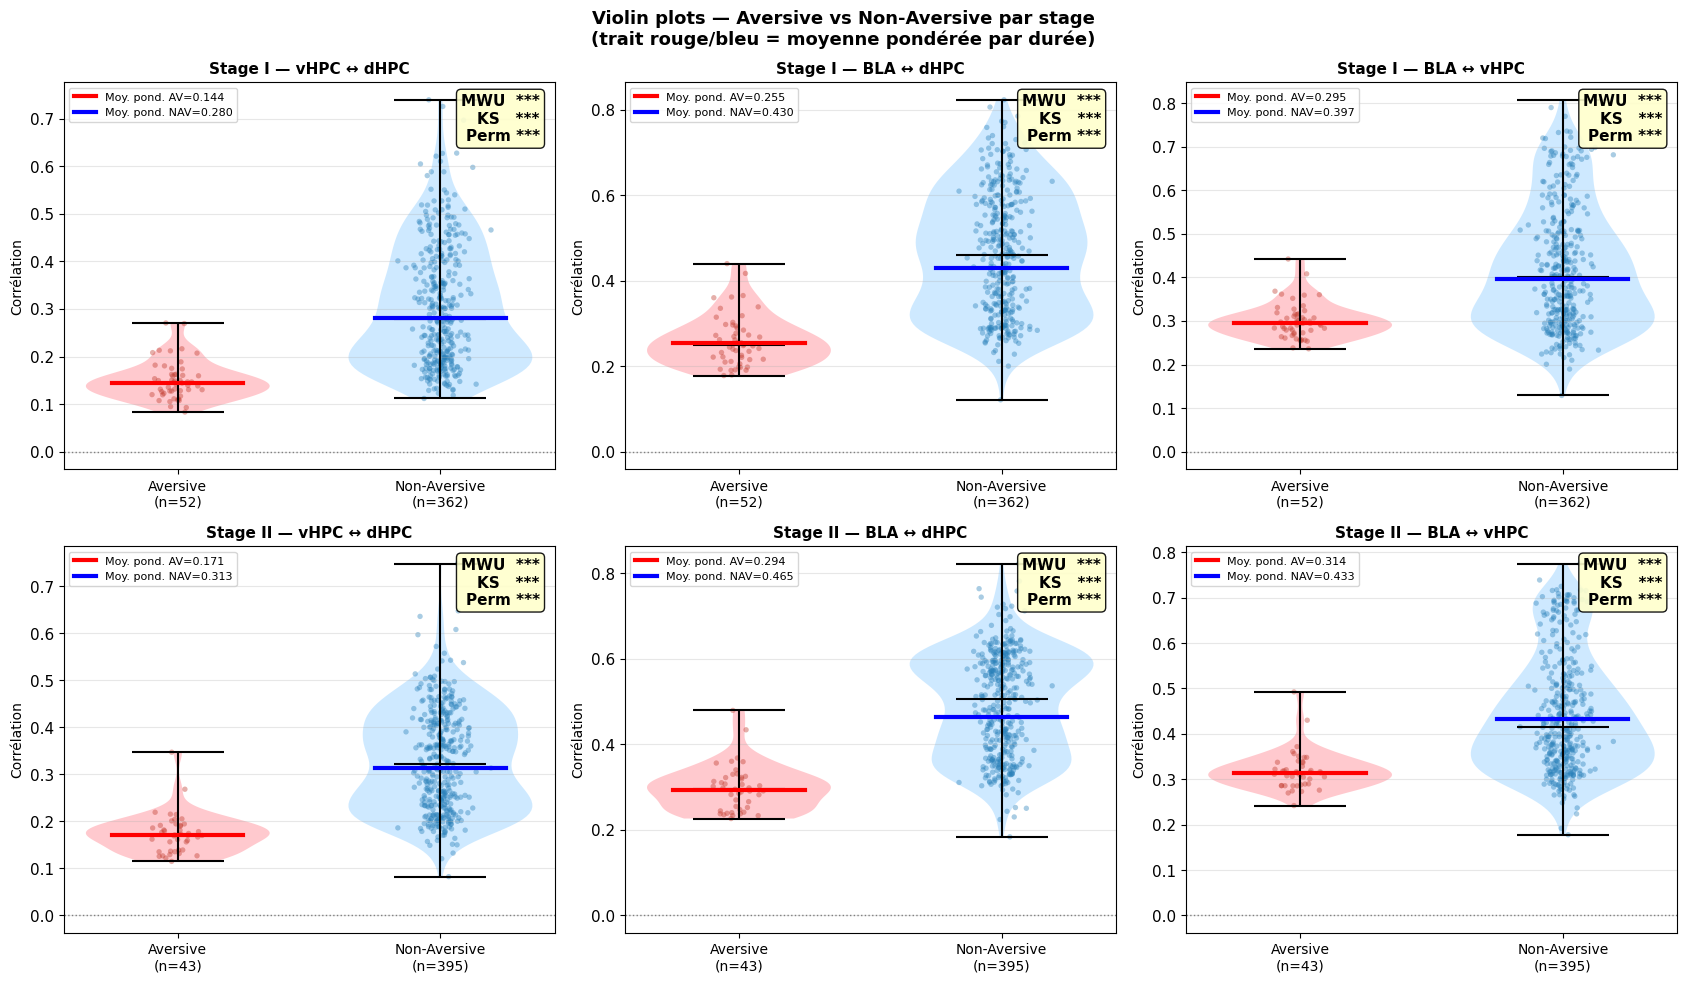

In [55]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

for si, (stage_label, _, _) in enumerate(STAGES):
    for pi, (n1, n2, pair_label, _) in enumerate(PAIRS):
        ax = axes[si, pi]

        d_av,  w_av  = all_corrs[(stage_label, 'Aversive',    pair_label)]
        d_nav, w_nav = all_corrs[(stage_label, 'Non-Aversive', pair_label)]

        if len(d_av) < 2 or len(d_nav) < 2:
            ax.text(0.5, 0.5, 'Données insuffisantes', ha='center', va='center',
                    transform=ax.transAxes)
            ax.set_title(f'{stage_label} — {pair_label}', fontsize=11, fontweight='bold')
            continue

        vp = ax.violinplot([d_av, d_nav], positions=[1, 2],
                           showmedians=True, widths=0.7)
        vp['bodies'][0].set_facecolor('#FFB3BA'); vp['bodies'][0].set_alpha(0.7)
        vp['bodies'][1].set_facecolor('#BAE1FF'); vp['bodies'][1].set_alpha(0.7)
        for part in ['cmedians', 'cbars', 'cmins', 'cmaxes']:
            vp[part].set_color('black'); vp[part].set_linewidth(1.5)

        np.random.seed(42)
        ax.scatter(np.random.normal(1, 0.05, len(d_av)),  d_av,
                   alpha=0.4, s=15, color='#c0392b', edgecolors='none')
        ax.scatter(np.random.normal(2, 0.05, len(d_nav)), d_nav,
                   alpha=0.4, s=15, color='#2980b9', edgecolors='none')

        # Moyennes pondérées
        wm_av,  _ = weighted_mean_std(d_av,  w_av)
        wm_nav, _ = weighted_mean_std(d_nav, w_nav)
        ax.plot([0.75, 1.25], [wm_av,  wm_av],  'r-', lw=3,
                label=f'Moy. pond. AV={wm_av:.3f}')
        ax.plot([1.75, 2.25], [wm_nav, wm_nav], 'b-', lw=3,
                label=f'Moy. pond. NAV={wm_nav:.3f}')

        # Résumé des tests
        res = test_results.get((stage_label, pair_label))
        if res:
            any_sig = min(res['mwu_p'], res['ks_p'], res['perm_p']) < 0.05
            ann = (f"MWU  {sig_label(res['mwu_p'])}\n"
                   f"KS   {sig_label(res['ks_p'])}\n"
                   f"Perm {sig_label(res['perm_p'])}")
            ax.text(0.97, 0.97, ann, transform=ax.transAxes, fontsize=11,
                    va='top', ha='right', fontweight='bold',
                    bbox=dict(boxstyle='round',
                              facecolor='#FFFFCC' if any_sig else '#F0F0F0',
                              alpha=0.9, edgecolor='black'))

        ax.set_xticks([1, 2])
        ax.set_xticklabels([f'Aversive\n(n={len(d_av)})',
                            f'Non-Aversive\n(n={len(d_nav)})'], fontsize=10)
        ax.set_ylabel('Corrélation', fontsize=10)
        ax.set_title(f'{stage_label} — {pair_label}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.axhline(0, color='gray', linestyle=':', lw=1)
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Violin plots — Aversive vs Non-Aversive par stage\n'
             '(trait rouge/bleu = moyenne pondérée par durée)',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## Corrélation globale + tableau comparatif des méthodes

In [56]:
print(f"{'Stage':<10} {'Paire':<18} {'Condition':<14} "
      f"{'Non-pondéré':>13} {'Pondéré':>13} {'Global':>13}")
print('=' * 85)

for stage_label, df_av, df_nav in STAGES:
    for n1, n2, pair_label, _ in PAIRS:
        for cond, df in [('Aversive', df_av), ('Non-Aversive', df_nav)]:
            d, w    = all_corrs[(stage_label, cond, pair_label)]
            um      = np.nanmean(d)
            wm, _   = weighted_mean_std(d, w)
            g, _    = compute_global_correlation(df, n1, n2)
            print(f"{stage_label:<10} {pair_label:<18} {cond:<14} "
                  f"{um:>+13.4f} {wm:>+13.4f} {g:>+13.4f}")
    print()

Stage      Paire              Condition        Non-pondéré       Pondéré        Global
Stage I    vHPC ↔ dHPC        Aversive             +0.1497       +0.1444       +0.1452
Stage I    vHPC ↔ dHPC        Non-Aversive         +0.3065       +0.2801       +0.3215
Stage I    BLA ↔ dHPC         Aversive             +0.2596       +0.2548       +0.2574
Stage I    BLA ↔ dHPC         Non-Aversive         +0.4657       +0.4296       +0.4913
Stage I    BLA ↔ vHPC         Aversive             +0.3001       +0.2951       +0.2972
Stage I    BLA ↔ vHPC         Non-Aversive         +0.4207       +0.3966       +0.4565

Stage II   vHPC ↔ dHPC        Aversive             +0.1738       +0.1707       +0.1715
Stage II   vHPC ↔ dHPC        Non-Aversive         +0.3280       +0.3127       +0.3511
Stage II   BLA ↔ dHPC         Aversive             +0.2970       +0.2945       +0.2964
Stage II   BLA ↔ dHPC         Non-Aversive         +0.4927       +0.4650       +0.5197
Stage II   BLA ↔ vHPC         Aversive    

## Tableau récapitulatif des tests statistiques

In [57]:
print("Tests de distribution — Aversive vs Non-Aversive")
print('=' * 100)
print(f"{'Stage':<10} {'Paire':<18} "
      f"{'MWU stat':>10} {'MWU p':>10} "
      f"{'KS stat':>9} {'KS p':>9} "
      f"{'Perm Δ':>9} {'Perm p':>9}")
print('-' * 100)

for stage_label, _, _ in STAGES:
    for _, _, pair_label, _ in PAIRS:
        res = test_results.get((stage_label, pair_label))
        if res is None:
            continue
        print(f"{stage_label:<10} {pair_label:<18} "
              f"{res['mwu_stat']:>10.0f} {res['mwu_p']:>9.4f} {sig_label(res['mwu_p']):<3} "
              f"{res['ks_stat']:>9.4f} {res['ks_p']:>8.4f} {sig_label(res['ks_p']):<3} "
              f"{res['perm_stat']:>+9.4f} {res['perm_p']:>8.4f} {sig_label(res['perm_p']):<3}")
    print()

print("Significativité : ns p>0.05  |  * p<0.05  |  ** p<0.01  |  *** p<0.001")

Tests de distribution — Aversive vs Non-Aversive
Stage      Paire                MWU stat      MWU p   KS stat      KS p    Perm Δ    Perm p
----------------------------------------------------------------------------------------------------
Stage I    vHPC ↔ dHPC              1634    0.0000 ***    0.6753   0.0000 ***   -0.1357   0.0000 ***
Stage I    BLA ↔ dHPC               1501    0.0000 ***    0.6748   0.0000 ***   -0.1748   0.0000 ***
Stage I    BLA ↔ vHPC               4175    0.0000 ***    0.5251   0.0000 ***   -0.1015   0.0000 ***

Stage II   vHPC ↔ dHPC              1122    0.0000 ***    0.7611   0.0000 ***   -0.1419   0.0000 ***
Stage II   BLA ↔ dHPC               1068    0.0000 ***    0.7465   0.0000 ***   -0.1705   0.0000 ***
Stage II   BLA ↔ vHPC               2820    0.0000 ***    0.6163   0.0000 ***   -0.1192   0.0000 ***

Significativité : ns p>0.05  |  * p<0.05  |  ** p<0.01  |  *** p<0.001
